In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import stats
import scipy.stats as ss

from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
import catboost as cat
from sklearn.linear_model import LogisticRegression
import category_encoders as ce
from category_encoders import MEstimateEncoder
from sklearn.model_selection import train_test_split
import optuna
from itertools import combinations

In [138]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [54]:
train['POSTAL_CODE']

0         37379
1         10238
2         10238
3         92099
4         32122
          ...  
104995    31885
104996    32277
104997    34800
104998    10238
104999    10238
Name: POSTAL_CODE, Length: 105000, dtype: int64

In [112]:
test.head()

,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,TYPE_OF_VEHICLE
0,352928,40-64,male,10-19y,none,working class,0.814707,1.0,after 2015,0.0,1.0,10238,10000.0,0,0,0,HatchBack
1,38579,26-39,female,20-29y,high school,upper class,0.344051,1.0,before 2015,0.0,0.0,34073,13000.0,0,0,0,Sedan
2,504022,40-64,male,10-19y,none,upper class,0.620691,0.0,after 2015,1.0,0.0,10238,12000.0,0,0,0,SUV
3,202404,26-39,male,20-29y,high school,upper class,0.689658,1.0,after 2015,1.0,1.0,10238,16000.0,1,0,0,SUV
4,527913,65+,male,10-19y,none,middle class,0.755666,0.0,after 2015,0.0,1.0,92101,14000.0,2,0,0,HatchBack


d:\python3.9\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='OUTCOME', ylabel='count'>

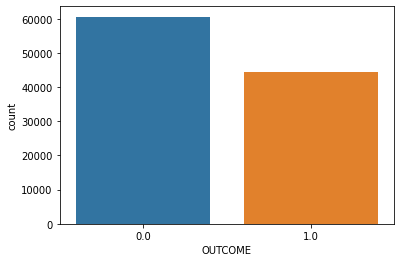

In [5]:
sns.countplot(train['OUTCOME'])

<AxesSubplot:xlabel='DRIVING_EXPERIENCE', ylabel='count'>

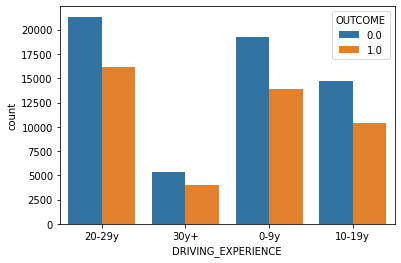

In [108]:
sns.countplot(x="DRIVING_EXPERIENCE", hue="OUTCOME", data=train)

<AxesSubplot:xlabel='ANNUAL_MILEAGE', ylabel='count'>

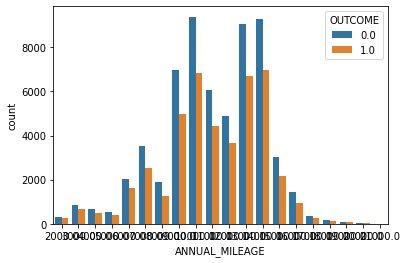

In [166]:
sns.countplot(x="ANNUAL_MILEAGE", hue="OUTCOME", data=train)

In [113]:
train['DRIVING_EXPERIENCE'].unique()

array(['20-29y', '30y+', '0-9y', '10-19y'], dtype=object)

In [24]:
len(test.columns)

33

In [14]:
train.columns

Index(['ID', 'AGE', 'GENDER', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'VEHICLE_YEAR', 'MARRIED',
       'CHILDREN', 'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS',
       'DUIS', 'PAST_ACCIDENTS', 'OUTCOME', 'TYPE_OF_VEHICLE'],
      dtype='object')

In [139]:
cat_cols = [ 'GENDER', 'EDUCATION', 'INCOME',
            'VEHICLE_YEAR','TYPE_OF_VEHICLE']

In [93]:
def cramers_v(x, y):
    
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [176]:
for i in train.columns:
    
    print(f'{i} correlation {cramers_v(train[i], train["OUTCOME"])}')

ID correlation 0.0
AGE correlation 0.0
GENDER correlation 0.011258020957786547
DRIVING_EXPERIENCE correlation 0.0137054683829392
EDUCATION correlation 0.0
INCOME correlation 0.0
CREDIT_SCORE correlation 0.0
VEHICLE_OWNERSHIP correlation 0.0
VEHICLE_YEAR correlation 0.0
MARRIED correlation 0.005154960958728126
CHILDREN correlation 0.0
POSTAL_CODE correlation 0.0
ANNUAL_MILEAGE correlation 0.012915204296091592
SPEEDING_VIOLATIONS correlation 0.009360608827442572
DUIS correlation 0.0
PAST_ACCIDENTS correlation 0.0
OUTCOME correlation 0.9999804851393885
TYPE_OF_VEHICLE correlation 0.009083320850949017
POSTAL_CODE_ANNUAL_MILEAGE_le correlation 0.012769372336969311
POSTAL_CODE_DRIVING_EXPERIENCE_le correlation 0.017818591171944807
POSTAL_CODE_PAST_ACCIDENTS_le correlation 0.006880013457381608
ANNUAL_MILEAGE_DRIVING_EXPERIENCE_le correlation 0.021432285873999035
ANNUAL_MILEAGE_PAST_ACCIDENTS_le correlation 0.01038771484412547
DRIVING_EXPERIENCE_PAST_ACCIDENTS_le correlation 0.0174701679401376

In [52]:
['AGE','EDUCATION','INCOME']

        POSTAL_CODE
0          0.000010
1          0.739124
2          0.739124
3          0.001476
4          0.000038
...             ...
104995     0.000029
104996     0.000019
104997     0.000048
104998     0.739124
104999     0.739124

[105000 rows x 1 columns]


In [95]:
def frequency_encoding(column_name,output_column_name,df):
    fe_pol = (df.groupby(column_name).size()) / len(df)
    df[output_column_name] = df[column_name].apply(lambda x : fe_pol[x])

In [96]:
def encoder(columnname, df):
    _count = ce.CountEncoder(cols=columnname)
    _count.fit(df[columnname])
    df[columnname] = _count.transform(df[columnname]) / df.shape[0]    

In [140]:
def feature_engineering(df, df1):
    
    
    for i in cat_cols:
        
        le = LabelEncoder()
        le.fit(df[i])
        df[i] = le.transform(df[i])
        df1[i] = le.transform(df1[i])
        
    
    #AGE_MAP = {'40-64':2, '26-39':1, '16-25':0, '65+':3}
    
    EXP_MAP = {'20-29y':2, '30y+':3, '0-9y':0, '10-19y':1}
    
    
    #df['AGE'] = df['AGE'].map(AGE_MAP)
    #df1['AGE'] = df1['AGE'].map(AGE_MAP)
    
    df['DRIVING_EXPERIENCE'] = df['DRIVING_EXPERIENCE'].map(EXP_MAP)
    df1['DRIVING_EXPERIENCE'] = df1['DRIVING_EXPERIENCE'].map(EXP_MAP)
    
    
    #df = pd.get_dummies(df, columns=cat_cols)
    
    #df1 = pd.get_dummies(df1, columns=cat_cols)
    
    
    #_count = ce.CountEncoder(cols='POSTAL_CODE')
    
    #_count.fit(df['POSTAL_CODE'])
    
    
    #df['POSTAL_CODE'] = _count.transform(df['POSTAL_CODE']) / df.shape[0]
    
    #df1['POSTAL_CODE'] = _count.transform(df1['POSTAL_CODE']) / df1.shape[0]
    
    #df['POSTAL_AGE'] = df['POSTAL_CODE'].astype(str) + '_' +df['DRIVING_EXPERIENCE'].astype(str)
    #df1['POSTAL_AGE'] = df1['POSTAL_CODE'].astype(str) + '_' +df1['DRIVING_EXPERIENCE'].astype(str)
    
    #print(df['POSTAL_AGE'])
    
    high_cardinal = ['POSTAL_CODE','ANNUAL_MILEAGE','DRIVING_EXPERIENCE','PAST_ACCIDENTS']
    
    
    comb = combinations(high_cardinal, 2) 

    for i in list(comb):
        df[f'{i[0]}_{i[1]}_le']=df[i[0]].astype(str)+'_'+df[i[1]].astype(str)
        df1[f'{i[0]}_{i[1]}_le']=df1[i[0]].astype(str)+'_'+df1[i[1]].astype(str)
        #df[f'{i[0]}_{i[1]}_le']=le.fit_transform(df[i[0]].astype(str)+'_'+df[i[1]].astype(str))
        frequency_encoding(f'{i[0]}_{i[1]}_le',f'{i[0]}_{i[1]}_le',df)
        frequency_encoding(f'{i[0]}_{i[1]}_le',f'{i[0]}_{i[1]}_le',df1)
    
    '''
    
    for i in high_cardinal:
        frequency_encoding(i, i,df)
        frequency_encoding(i, i,df1)
    '''
    
    
    
    return df, df1

In [141]:
train, test = feature_engineering(train, test)

In [142]:
train

,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,...,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE,POSTAL_CODE_ANNUAL_MILEAGE_le,POSTAL_CODE_DRIVING_EXPERIENCE_le,POSTAL_CODE_PAST_ACCIDENTS_le,ANNUAL_MILEAGE_DRIVING_EXPERIENCE_le,ANNUAL_MILEAGE_PAST_ACCIDENTS_le,DRIVING_EXPERIENCE_PAST_ACCIDENTS_le
0,816393,40-64,0,2,2,0,0.638050,0.0,0,0.0,...,0,0,0.0,3,0.000010,0.000010,0.000010,0.035648,0.074210,0.267352
1,251762,26-39,1,2,0,0,0.475741,1.0,1,1.0,...,0,0,1.0,0,0.085381,0.263648,0.558629,0.040638,0.086095,0.267352
2,481952,40-64,1,2,1,0,0.839817,1.0,1,1.0,...,0,0,1.0,2,0.060000,0.263648,0.558629,0.029200,0.061267,0.267352
3,3506,40-64,1,2,0,2,0.682527,1.0,1,0.0,...,0,0,1.0,2,0.000057,0.000457,0.001076,0.012200,0.026171,0.267352
4,498013,40-64,0,2,1,3,0.572184,1.0,0,1.0,...,0,1,0.0,2,0.000010,0.000010,0.000019,0.017448,0.006276,0.048095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,19557,65+,0,0,0,2,0.672255,1.0,1,0.0,...,0,0,0.0,1,0.000010,0.000019,0.000029,0.035238,0.086095,0.237086
104996,222459,40-64,0,0,1,3,0.514193,1.0,0,1.0,...,0,0,1.0,2,0.000019,0.000019,0.000019,0.048638,0.115829,0.237086
104997,83089,16-25,1,1,1,2,0.461942,1.0,0,1.0,...,0,0,1.0,2,0.000019,0.000038,0.000048,0.023714,0.074210,0.179448
104998,984879,40-64,0,2,0,3,0.483571,1.0,1,0.0,...,0,0,0.0,0,0.113533,0.263648,0.558629,0.054895,0.115829,0.267352


In [13]:
train['ANNUAL_MILEAGE'] = train['ANNUAL_MILEAGE'].astype('int64')
test['ANNUAL_MILEAGE'] = test['ANNUAL_MILEAGE'].astype('int64')


In [7]:
#del test['OUTCOME']

In [84]:
train.drop(['ID','OUTCOME','AGE', 'INCOME','EDUCATION','VEHICLE_YEAR'],axis=1).columns

Index(['GENDER', 'DRIVING_EXPERIENCE', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP',
       'MARRIED', 'CHILDREN', 'POSTAL_CODE', 'ANNUAL_MILEAGE',
       'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS', 'TYPE_OF_VEHICLE'],
      dtype='object')

In [122]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [30]:
train.drop(['ID','OUTCOME','AGE','EDUCATION','INCOME'],axis=1).columns

Index(['GENDER', 'DRIVING_EXPERIENCE', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP',
       'VEHICLE_YEAR', 'MARRIED', 'CHILDREN', 'POSTAL_CODE', 'ANNUAL_MILEAGE',
       'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS', 'TYPE_OF_VEHICLE'],
      dtype='object')

In [156]:
x_train = train.drop(['ID','OUTCOME','AGE','EDUCATION','INCOME'],axis=1)
y_train = train['OUTCOME']

In [157]:
X_train,X_val,Y_train,Y_val = train_test_split(x_train,y_train,random_state=42)

In [158]:
X_train, X_eval, Y_train, Y_eval = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [159]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_eval.shape, Y_eval.shape

((70875, 19), (70875,), (26250, 19), (26250,), (7875, 19), (7875,))

In [160]:
def check_logloss(model,x_val,y_val):
    pred = model.predict_proba(x_val)[:,1]
    return log_loss(y_val, pred)

In [162]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.1, 0.001)
    param['depth'] = trial.suggest_int('depth', 5, 11)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.0, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise'
    param['iterations'] = 3000
    param['use_best_model'] = True
    param['eval_metric'] = 'Logloss'
    param['od_type'] = 'iter'
    param['od_wait'] = 100
    param['random_state'] = 42
    param['logging_level'] = 'Silent'
    
    classifier = cat.CatBoostClassifier(**param)
    classifier.fit(X_train.copy(), Y_train.copy(),
                  eval_set=[(X_eval.copy(), Y_eval.copy())],
                  early_stopping_rounds=100)
    return check_logloss(classifier,X_val,Y_val)

In [163]:
%%time
study = optuna.create_study(study_name='catboost-seed')
study.optimize(objective, n_trials=5, n_jobs=-1, timeout=24000)

[I 2022-10-29 12:17:21,134] A new study created in memory with name: catboost-seed
d:\python3.9\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-10-29 12:17:37,564] Trial 2 finished with value: 0.6816509872422851 and parameters: {'learning_rate': 0.07200000000000001, 'depth': 5, 'l2_leaf_reg': 3.5, 'min_child_samples': 8}. Best is trial 2 with value: 0.6816509872422851.
[I 2022-10-29 12:17:41,958] Trial 3 finished with value:

Wall time: 25.5 s


In [82]:
study.best_value

0.6815455985505945

In [83]:
study.best_params

{'learning_rate': 0.013000000000000001,
 'depth': 2,
 'l2_leaf_reg': 1.0,
 'min_child_samples': 8}

In [150]:
def train_with_cat(train, test=None,  _eval=True):
    
    '''
    params_lgb = {
        #num_iterations': 1000,
        'n_estimators': 3000,
        'learning_rate': 0.1,
        'objective':'binary',
        'metric':'binary_logloss',
        'num_leaves':500,
        
        'lambda_l2':2,
        'lambda_l1':3,
        #'min_gain_to_split': 5,
        #'min_data_in_leaf': 100,
        
        #'bagging_fraction': 0.7,
        #'feature_fraction': 0.9,
        #'min_gain_to_split': 40,
        
        'seed':42,
        #'device':'gpu'
        
    }
    '''
    
    params_cat = {'learning_rate': 0.05, 'depth': 7, 
                  #'l2_leaf_reg': 2.5, 'min_child_samples': 4,
                  'iterations':3000,
                  'random_state':42}
    #params_cat = study.best_params
    
    
    # Split features and target
    x = train.drop(['ID','OUTCOME','AGE','EDUCATION','INCOME'],axis=1)
    y = train['OUTCOME']
    x_test = test.drop(['ID','AGE','EDUCATION','INCOME'], axis=1)
    
    
    
    
    #print(x.shape[0])
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    #oof_predictions1 = np.zeros(x.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(x_test.shape[0])
    #test_predictions1 = np.zeros(x_test.shape[0])
    # Create a KFold object
    
    kfold = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
    
    
    # Iterate through each fold
    for fold , (trn_ind, val_ind) in enumerate(kfold.split(x,y)):
        #print("TRAIN:", trn_ind, "TEST:", val_ind)
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        
        
        
        
       
        #train_dataset = lgb.Dataset(x_train, y_train,  categorical_feature = [ 'GENDER', 'DRIVING_EXPERIENCE', 'TYPE_OF_VEHICLE','POSTAL_CODE'])
        #val_dataset = lgb.Dataset(x_val, y_val,  categorical_feature = [ 'GENDER', 'DRIVING_EXPERIENCE', 'TYPE_OF_VEHICLE','POSTAL_CODE'])
       
        
        
        '''
        
        model = lgb.train(params = params_lgb, 
                    train_set = train_dataset, 
                    valid_sets =  [train_dataset,val_dataset], 
                    num_boost_round = 1000,
                    early_stopping_rounds = 100,
                    verbose_eval = 500
                    )
       '''
        
        '''
        
        for i in high_cardinal:
            _count = MEstimateEncoder(m=3.5, cols=i)
            _count.fit(x_train[i], y_train)
            
            x_train[i] =  _count.transform(x_train[i]) 
            x_val[i] = _count.transform(x_val[i]) 
            x_test[i] = _count.transform(x_test[i]) 
            
            print(x_test[i])
            '''
    
        #print(df1['POSTAL_CODE'])
        
        
        #light = lgb.LGBMClassifier(**params_lgb)
        model = cat.CatBoostClassifier(**params_cat)
        
        #light.fit(x_train, y_train, eval_set=(x_val, y_val), categorical_feature=[ 'GENDER', 'DRIVING_EXPERIENCE', 'TYPE_OF_VEHICLE','POSTAL_CODE'], 
        #          early_stopping_rounds = 100, verbose=10)
        
        #model = cat.CatBoostRegressor(loss_function='MAPE', learning_rate=0.3, cat_features=[13],random_seed=42, max_depth=10, l2_leaf_reg=0.8,min_data_in_leaf=500 )
        
        
        model.fit(x_train, y_train, early_stopping_rounds=100, verbose=500, plot=True,eval_set=(x_val, y_val),use_best_model=True)
        
        
        #light_val = light.predict_proba(x_val)[:,1]
        val = model.predict_proba(x_val)[:,1]
        
        
        print(f' current fold log loss is {log_loss(y_val,val)}')
        
        
        
        
        oof_predictions[val_ind] =  val
        #oof_predictions1[val_ind] =  light_val
        
        
        # Predict the test set
        
        #light_pred = light.predict_proba(x_test)[:,1]
        pred = model.predict_proba(x_test)[:,1]
        
        
        '''
        plt.figure(figsize=(12,6))
        lgb.plot_importance(light, max_num_features=30)
        plt.title("Feature importance")
        plt.show()
        '''
        
        plot_feature_importance(model.get_feature_importance(), x.columns, 'CATBOOST')
        
        test_predictions += pred
        #test_predictions1 += light_pred
        
        
        
        
    
    mean_score = log_loss(y, oof_predictions)
    #mean_score1 = log_loss(y, oof_predictions1)
    
    
    print(f'Our out of folds log loss for catboost is {mean_score}')
    #print(f'Our out of folds log loss for  lightgbm is {mean_score1}')
    
    
    
    
    if _eval:
        return mean_score, oof_predictions
    else:
        return oof_predictions, [x/5 for x in test_predictions]

In [151]:
def train_with_light(train, test=None,  _eval=True):
    
    params_lgb = {
        #num_iterations': 1000,
        'n_estimators': 3000,
        'learning_rate': 0.1,
        'objective':'binary',
        'metric':'binary_logloss',
        #'num_leaves':500,
        
        #'lambda_l2':2,
        #'lambda_l1':3,
        #'min_gain_to_split': 5,
        #'min_data_in_leaf': 100,
        
        #'bagging_fraction': 0.7,
        #'feature_fraction': 0.9,
        #'min_gain_to_split': 40,
        
        'seed':42,
        #'device':'gpu'
        
    }
    
    
    
    # Split features and target
    x = train.drop(['ID','OUTCOME'],axis=1)
    y = train['OUTCOME']
    x_test = test.drop(['ID'], axis=1)
    
    
    
    
    #print(x.shape[0])
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    #oof_predictions1 = np.zeros(x.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(x_test.shape[0])
    #test_predictions1 = np.zeros(x_test.shape[0])
    # Create a KFold object
    
    kfold = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
    
    
    # Iterate through each fold
    for fold , (trn_ind, val_ind) in enumerate(kfold.split(x,y)):
        #print("TRAIN:", trn_ind, "TEST:", val_ind)
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        
        
        
        
       
        #train_dataset = lgb.Dataset(x_train, y_train,  categorical_feature = [ 'GENDER', 'DRIVING_EXPERIENCE', 'TYPE_OF_VEHICLE','POSTAL_CODE'])
        #val_dataset = lgb.Dataset(x_val, y_val,  categorical_feature = [ 'GENDER', 'DRIVING_EXPERIENCE', 'TYPE_OF_VEHICLE','POSTAL_CODE'])
       
        
        
        '''
        
        model = lgb.train(params = params_lgb, 
                    train_set = train_dataset, 
                    valid_sets =  [train_dataset,val_dataset], 
                    num_boost_round = 1000,
                    early_stopping_rounds = 100,
                    verbose_eval = 500
                    )
       '''
        
        light = lgb.LGBMClassifier(**params_lgb)
        #model = cat.CatBoostClassifier(learning_rate=0.1, iterations=3000,objective='Logloss', random_seed=42, 
        #                               max_depth=7)
        
        light.fit(x_train, y_train, eval_set=(x_val, y_val), categorical_feature=['POSTAL_CODE'], 
                  early_stopping_rounds = 100, verbose=10)
        
        #model = cat.CatBoostRegressor(loss_function='MAPE', learning_rate=0.3, cat_features=[13],random_seed=42, max_depth=10, l2_leaf_reg=0.8,min_data_in_leaf=500 )
        
        
        #model.fit(x_train, y_train, cat_features=[0,1,6,11],early_stopping_rounds=100, verbose=500, plot=True,eval_set=(x_val, y_val),use_best_model=True)
        
        
        val = light.predict_proba(x_val)[:,1]
        #val = model.predict_proba(x_val)[:,1]
        
        
        print(f' current fold log loss is {log_loss(y_val,val)}')
        
        
        
        
        oof_predictions[val_ind] =  val
        #oof_predictions1[val_ind] =  light_val
        
        
        # Predict the test set
        
        pred = light.predict_proba(x_test)[:,1]
       # pred = model.predict_proba(x_test)[:,1]
        
        
        
        plt.figure(figsize=(12,6))
        lgb.plot_importance(light, max_num_features=30)
        plt.title("Feature importance")
        plt.show()
        
        
        #plot_feature_importance(model.get_feature_importance(), x.columns, 'CATBOOST')
        
        test_predictions += pred
        #test_predictions1 += light_pred
        
        
        
        
    
    mean_score = log_loss(y, oof_predictions)
    #mean_score1 = log_loss(y, oof_predictions1)
    
    
    print(f'Our out of folds log loss for catboost is {mean_score}')
    #print(f'Our out of folds log loss for  lightgbm is {mean_score1}')
    
    
    
    
    if _eval:
        return mean_score, oof_predictions
    else:
        return oof_predictions, [x/5 for x in test_predictions]

Training fold 1


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6919369	test: 0.6919664	best: 0.6919664 (0)	total: 47.8ms	remaining: 2m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.681385529
bestIteration = 54

Shrink model to first 55 iterations.
 current fold log loss is 0.6813855290381491
Training fold 2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6919435	test: 0.6919545	best: 0.6919545 (0)	total: 56.5ms	remaining: 2m 49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6810465442
bestIteration = 50

Shrink model to first 51 iterations.
 current fold log loss is 0.6810465442012251
Training fold 3


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6919311	test: 0.6919584	best: 0.6919584 (0)	total: 32.3ms	remaining: 1m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6809704492
bestIteration = 65

Shrink model to first 66 iterations.
 current fold log loss is 0.6809704491783888
Training fold 4


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6919318	test: 0.6919693	best: 0.6919693 (0)	total: 42.4ms	remaining: 2m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6811174832
bestIteration = 66

Shrink model to first 67 iterations.
 current fold log loss is 0.6811174832118065
Training fold 5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6919313	test: 0.6919785	best: 0.6919785 (0)	total: 51ms	remaining: 2m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6811192292
bestIteration = 55

Shrink model to first 56 iterations.
 current fold log loss is 0.6811192292308899
Our out of folds log loss for catboost is 0.6811278469720919


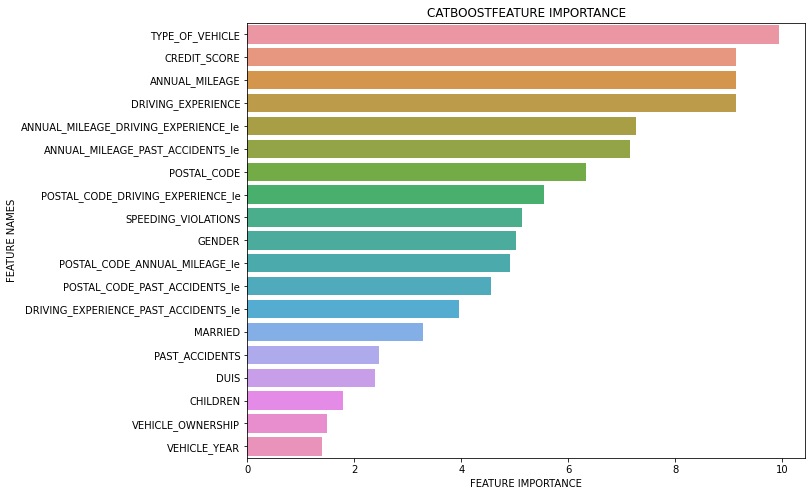

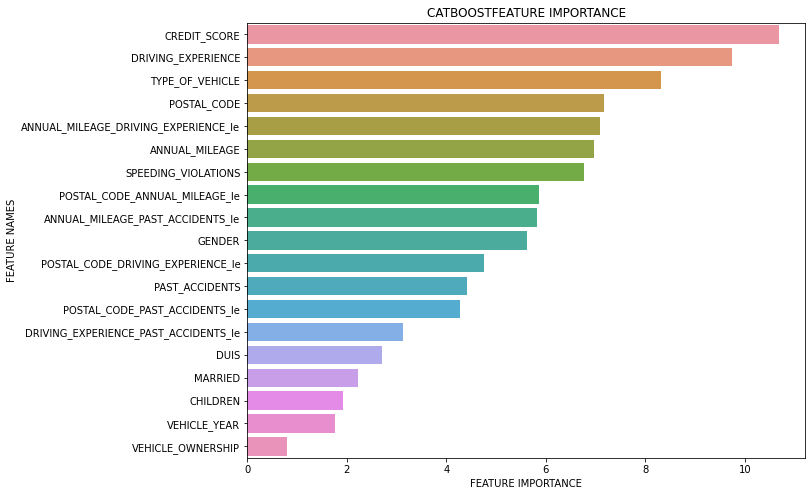

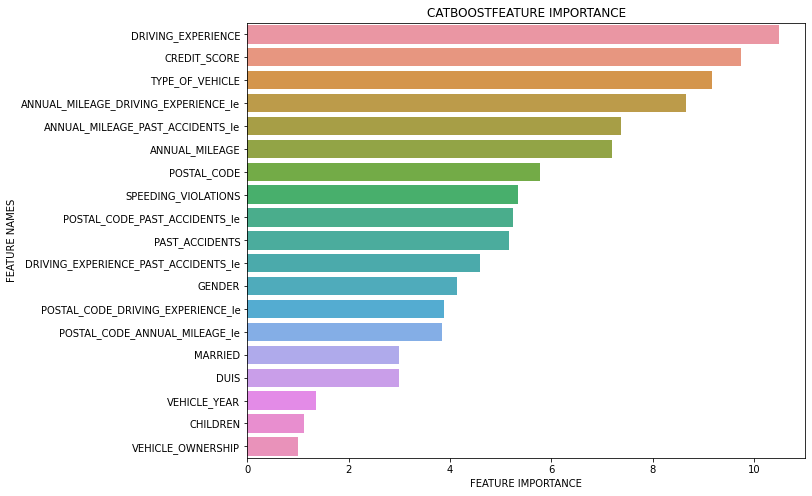

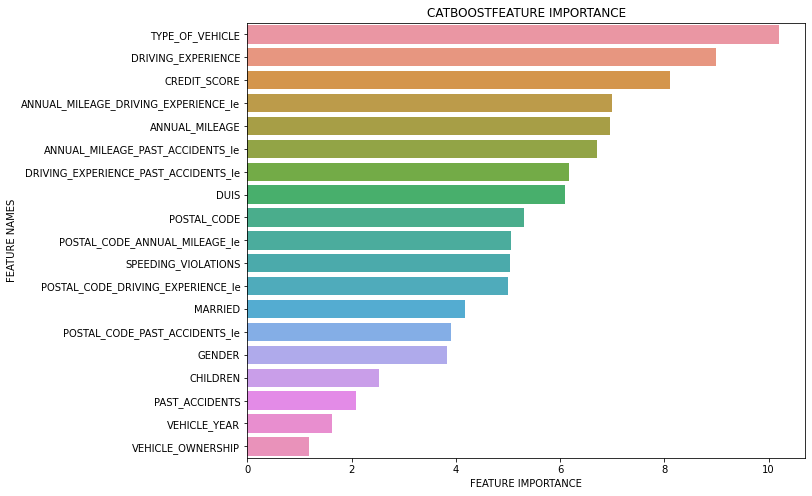

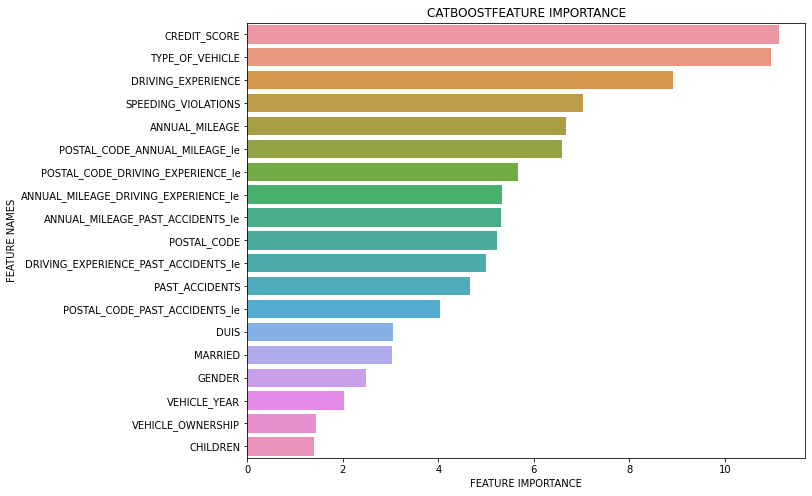

In [152]:
oof, test_pred = train_with_cat(train, test, _eval=False)

In [166]:
train['pred'] = oof
test['pred'] = test_pred

Training fold 1


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6919262	test: 0.6919618	best: 0.6919618 (0)	total: 26.8ms	remaining: 1m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6812838587
bestIteration = 64

Shrink model to first 65 iterations.
 current fold log loss is 0.6812838587255223
Training fold 2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6919275	test: 0.6919634	best: 0.6919634 (0)	total: 40.5ms	remaining: 2m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6810924578
bestIteration = 153

Shrink model to first 154 iterations.
 current fold log loss is 0.6810924577885877
Training fold 3


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6919236	test: 0.6919698	best: 0.6919698 (0)	total: 32.8ms	remaining: 1m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6809454964
bestIteration = 57

Shrink model to first 58 iterations.
 current fold log loss is 0.6809454964348889
Training fold 4


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6919221	test: 0.6919729	best: 0.6919729 (0)	total: 21.9ms	remaining: 1m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6809904184
bestIteration = 68

Shrink model to first 69 iterations.
 current fold log loss is 0.6809904183523291
Training fold 5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6919247	test: 0.6919725	best: 0.6919725 (0)	total: 25.2ms	remaining: 1m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6811872911
bestIteration = 64

Shrink model to first 65 iterations.
 current fold log loss is 0.6811872911372335
Our out of folds log loss for catboost is 0.6810999044877124


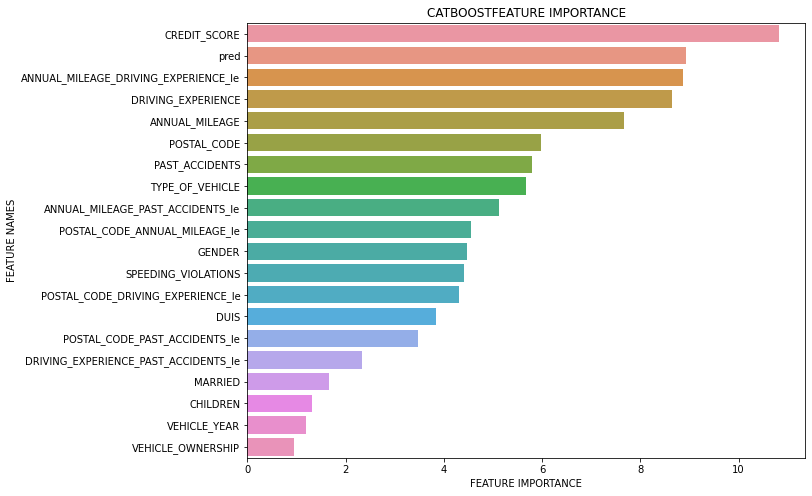

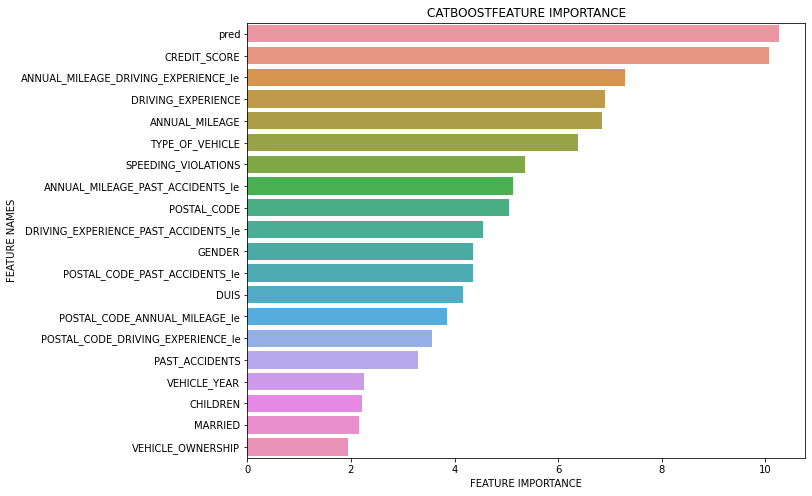

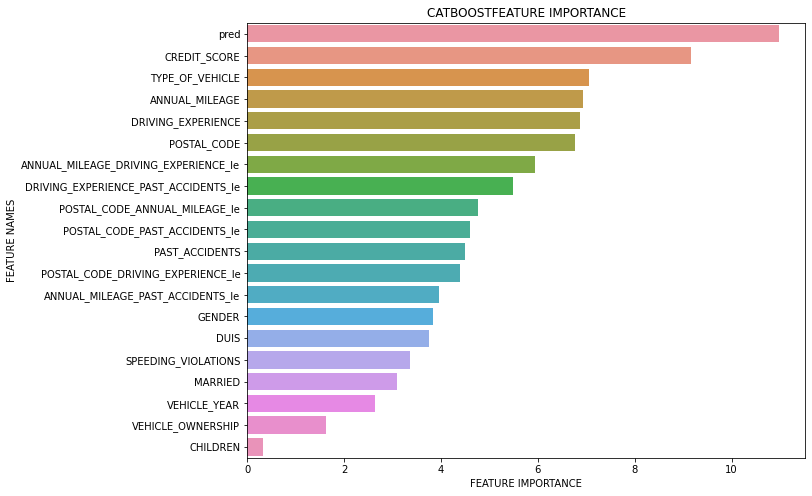

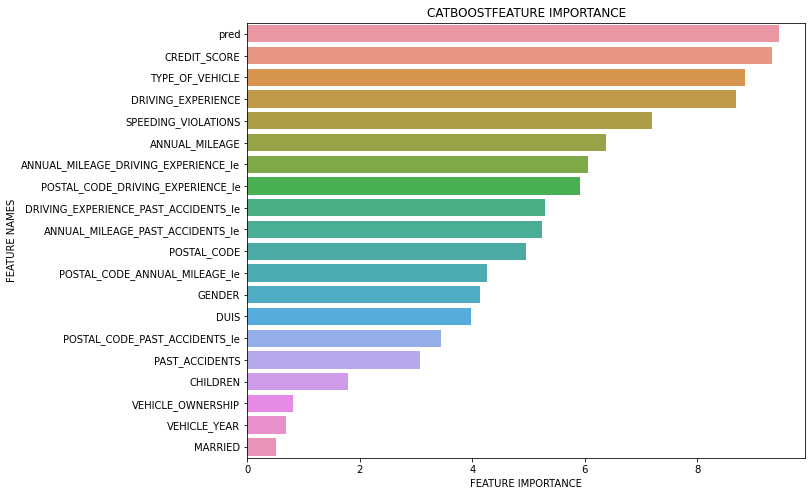

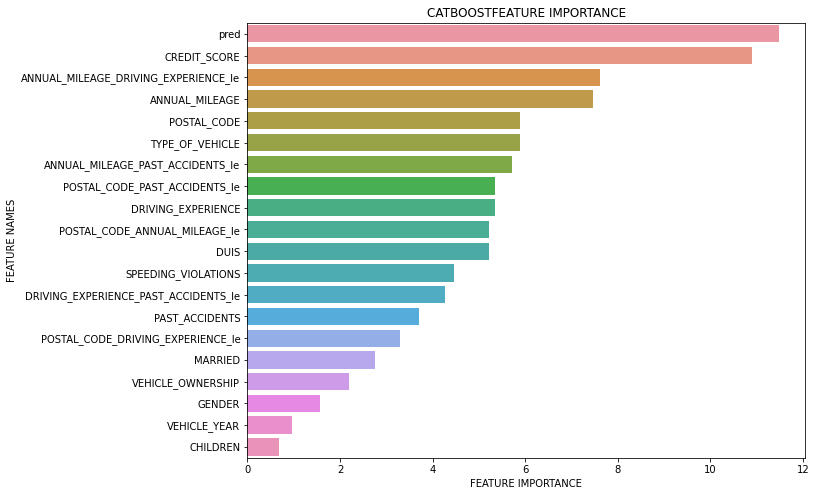

In [167]:
oof1, test_pred1 = train_with_cat(train, test, _eval=False)

In [54]:
trainpred = pd.DataFrame({'cat':oof, 'light':oof1,'OUTCOME': train['OUTCOME'] })
testpred = pd.DataFrame({'cat':test_pred, 'light':test_pred1})

In [41]:
log_loss(train['OUTCOME'], oof)

0.6810265499695748

In [55]:
trainpred['mean'] = trainpred.drop(['OUTCOME'],axis=1).mean(axis=1)
trainpred['diff'] = trainpred['cat'] - trainpred['light']


In [56]:
testpred['mean'] = testpred.mean(axis=1)
testpred['diff'] = testpred['cat'] - testpred['light']


In [57]:
testpred

,cat,light,mean,diff
0,0.422158,0.422066,0.422112,0.000092
1,0.439659,0.429319,0.434489,0.010339
2,0.414391,0.416117,0.415254,-0.001726
3,0.409157,0.418718,0.413938,-0.009561
4,0.423671,0.419037,0.421354,0.004634
...,...,...,...,...
44995,0.438840,0.430372,0.434606,0.008468
44996,0.424597,0.424431,0.424514,0.000166
44997,0.418341,0.416076,0.417209,0.002265
44998,0.417379,0.424408,0.420894,-0.007029


In [78]:
def ensemble(train, test=None,  _eval=True):
    
    params_lgb = {
        #num_iterations': 1000,
        'n_estimators': 3000,
        'learning_rate': 0.1,
        'objective':'binary',
        'metric':'binary_logloss',
        #'num_leaves':500,
        
        #'lambda_l2':2,
        #'lambda_l1':3,
        #'min_gain_to_split': 5,
        #'min_data_in_leaf': 100,
        
        #'bagging_fraction': 0.7,
        #'feature_fraction': 0.9,
        #'min_gain_to_split': 40,
        'seed':42,
        #'device':'gpu'
        
    }
    
    
    
    # Split features and target
    x = train.drop(['OUTCOME'],axis=1)
    y = train['OUTCOME']
    x_test = test
    
    #print(x.shape[0])
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    #oof_predictions1 = np.zeros(x.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(x_test.shape[0])
    #test_predictions1 = np.zeros(x_test.shape[0])
    # Create a KFold object
    
    kfold = KFold(n_splits = 5, random_state=42, shuffle=True)
    
    
    # Iterate through each fold
    for fold , (trn_ind, val_ind) in enumerate(kfold.split(x)):
        #print("TRAIN:", trn_ind, "TEST:", val_ind)
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        
        
        
        
       
        #train_dataset = lgb.Dataset(x_train, y_train,  categorical_feature = [ 'GENDER', 'DRIVING_EXPERIENCE', 'TYPE_OF_VEHICLE'])
        #val_dataset = lgb.Dataset(x_val, y_val,  categorical_feature = [ 'GENDER', 'DRIVING_EXPERIENCE', 'TYPE_OF_VEHICLE'])
       
        
        
        '''
        
        model = lgb.train(params = params_lgb, 
                    train_set = train_dataset, 
                    valid_sets =  [train_dataset,val_dataset], 
                    num_boost_round = 1000,
                    early_stopping_rounds = 100,
                    verbose_eval = 500
                    )
       '''
        model  = LogisticRegression(random_state=42)
        #light = lgb.LGBMClassifier(**params_lgb)
        #model = cat.CatBoostClassifier(learning_rate=0.1, iterations=3000,objective='Logloss', random_seed=42, max_depth=7)
        
        #light.fit(x_train, y_train, eval_set=(x_val, y_val), categorical_feature=[ 'GENDER', 'DRIVING_EXPERIENCE', 'TYPE_OF_VEHICLE'], 
        #          early_stopping_rounds = 100, verbose=10)
        
        #model = cat.CatBoostRegressor(loss_function='MAPE', learning_rate=0.3, cat_features=[13],random_seed=42, max_depth=10, l2_leaf_reg=0.8,min_data_in_leaf=500 )
        
        
        #model.fit(x_train, y_train, cat_features=[0,1,11],early_stopping_rounds=100, verbose=500, plot=True,eval_set=(x_val, y_val),use_best_model=True)
        
        model.fit(x_train, y_train)
        #light_val = light.predict_proba(x_val)[:,1]
        val = model.predict_proba(x_val)[:,1]
        
        
        print(f' current fold log loss is {log_loss(y_val,val)}')
        
        
        
        
        oof_predictions[val_ind] =  val
        #oof_predictions1[val_ind] =  light_val
        
        
        # Predict the test set
        
        #light_pred = light.predict_proba(x_test)[:,1]
        pred = model.predict_proba(x_test)[:,1]
        
        
        '''
        plt.figure(figsize=(12,6))
        cat.plot_importance(model, max_num_features=30)
        plt.title("Feature importance")
        plt.show()
        '''
        
        #plot_feature_importance(model.get_feature_importance(), x.columns, 'CATBOOST')
        
        test_predictions += pred
        #test_predictions1 += light_pred
        
        
        
        
    
    mean_score = log_loss(y, oof_predictions)
    
    print(f'Our out of folds log loss is {mean_score}')
    
    
    
    
    if _eval:
        return mean_score, oof_predictions
    else:
        return oof_predictions, [x/5 for x in test_predictions]

In [77]:
oof3, test_pred3 = ensemble(trainpred, testpred, _eval=False)

Training fold 1
 current fold log loss is 0.6816735311451537
Training fold 2
 current fold log loss is 0.6821815952399823
Training fold 3
 current fold log loss is 0.6824290647113386
Training fold 4
 current fold log loss is 0.682626097741874
Training fold 5
 current fold log loss is 0.6797955578697367
Our out of folds log loss is 0.681741169341617


In [171]:
submission = pd.DataFrame({"pred":test_pred,"pred1": test_pred1})
#submission.to_csv('submission_v17.csv', index=False)

In [173]:
submission['OUTCOME'] = submission['pred'] * 0.5 + submission['pred1'] * 0.5

In [175]:
submission['OUTCOME'].to_csv('submission_v18.csv', index=False)

In [31]:
submission.shape

(45000, 1)

In [20]:
sample = pd.read_csv('submission.csv')

In [21]:
sample.shape

(45000, 1)

In [22]:
test.shape

(45000, 17)

In [23]:
testpred.shape

(45000, 2)

21000.0